<a href="https://colab.research.google.com/github/infizest/MHA-2342/blob/main/AeroDreams_International_Airlines_Passenger_Satisfaction_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AeroDreams International Airlines: Passenger Satisfaction Data Analysis

# Step 1: Import Required Libraries


In [4]:
# Essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# libraries I needed for ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Step 2: Loading the Dataset with Error Handling

In [5]:
file_path = '/content/AeroDreams_DATA_CW6.csv'

try:
    df = pd.read_csv(file_path, encoding='ISO-8859-1')  # Using encoding
    print("✅ Data Loaded Successfully")
except FileNotFoundError:
    print("Error: File not found. Check the file path.")
except UnicodeDecodeError as e:
    print(f"Encoding Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

# first few rows
if 'df' in locals():
    print("Dataset Shape:", df.shape)
    display(df.head())


✅ Data Loaded Successfully
Dataset Shape: (103904, 27)


,Ref,id,Gender,Satisfied,Age,Age Band,Type of Travel,Class,Flight Distance,Destination,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,70172,Male,Y,13,Under 18,Personal Travel,Eco Plus,4760,India,...,5,5,4,3,4,4,5,5,25,18.0
1,1,5047,Male,N,25,25 to 34,Business travel,Business,235,Republic of Ireland,...,1,1,1,5,3,1,4,1,1,6.0
2,2,110028,Female,Y,26,25 to 34,Business travel,Business,4760,India,...,5,5,4,3,4,4,4,5,0,0.0
3,3,24026,Female,Y,25,25 to 34,Business travel,Business,560,Norway,...,2,2,2,5,3,1,4,2,11,9.0
4,4,119299,Male,Y,61,55 to 64,Business travel,Business,4760,India,...,5,3,3,4,4,3,3,3,0,0.0


# Step 3: Data Preprocessing

**Checking for missing values**

In [6]:
# Check for missing values
print("\n Missing values before handling:\n", df.isnull().sum())

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Fill missing values
for column in df.columns:
    if df[column].dtype == "object":
        df[column] = df[column].fillna(df[column].mode()[0])  # Assign back explicitly
    else:
        df[column] = df[column].fillna(df[column].median())  # Assign back explicitly

print("\n Missing values after handling:\n", df.isnull().sum())


 Missing values before handling:
 Ref                                    0
id                                     0
Gender                                 0
Satisfied                              0
Age                                    0
Age Band                               0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Destination                            0
Continent                              0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service      

# Handle Outliers (IQR Method)

In [7]:
# numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns

# Compute Q1, Q3, and IQR
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Filtering out outliers
df_cleaned = df[~((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"\n Outliers handled successfully! {df.shape[0] - df_cleaned.shape[0]} rows removed.")

# cleaned dataset back to df
df = df_cleaned



 Outliers handled successfully! 41901 rows removed.


# Convert Categorical to Numerical Features

In [8]:
label_encoder = LabelEncoder()

categorical_cols = ['Gender', 'Type of Travel', 'Class', 'Destination', 'Continent']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Check transformed dataset
df.head()


,Ref,id,Gender,Satisfied,Age,Age Band,Type of Travel,Class,Flight Distance,Destination,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,70172,1,Y,13,Under 18,1,2,4760,0,...,5,5,4,3,4,4,5,5,25,18.0
2,2,110028,0,Y,26,25 to 34,0,0,4760,0,...,5,5,4,3,4,4,4,5,0,0.0
4,4,119299,1,Y,61,55 to 64,0,0,4760,0,...,5,3,3,4,4,3,3,3,0,0.0
6,6,82113,1,Y,47,45 to 54,1,1,4760,0,...,2,2,3,3,4,3,5,2,9,23.0
7,7,96462,0,Y,52,45 to 54,0,0,4760,0,...,5,5,5,5,5,4,5,4,4,0.0


# Step 4: Exploratory Data Analysis (EDA)

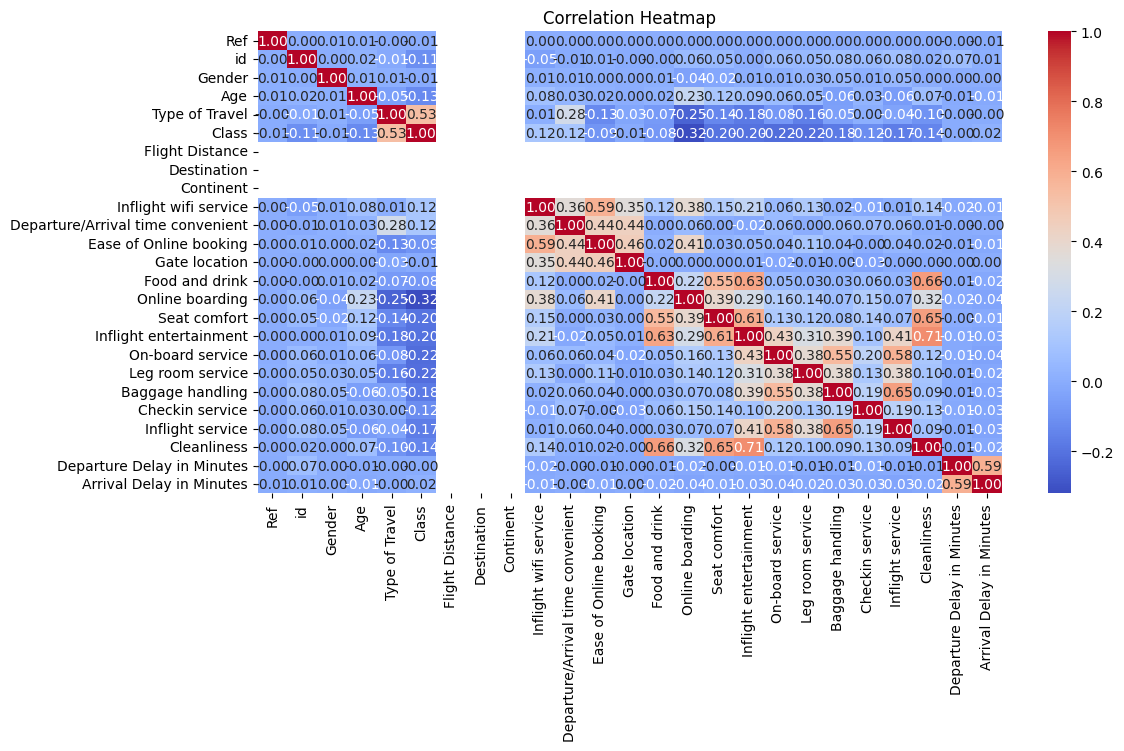

In [9]:
# numerical columns
numerical_cols = df.select_dtypes(include=['number'])

# correlation matrix
corr_matrix = numerical_cols.corr()

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


# Distribution of Passenger Satisfaction

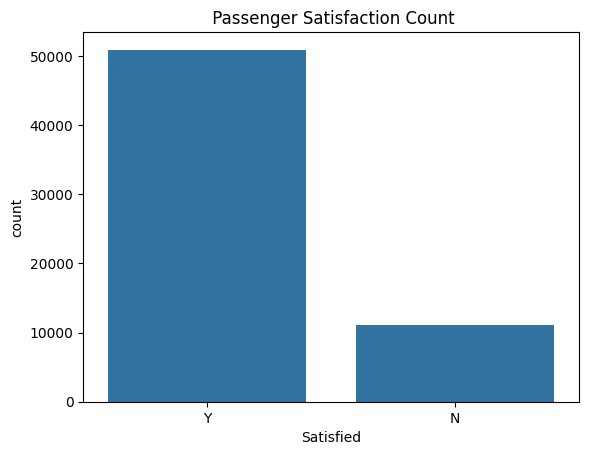

In [10]:
sns.countplot(x=df['Satisfied'])
plt.title(" Passenger Satisfaction Count")
plt.show()

# Pairplot of Key Features

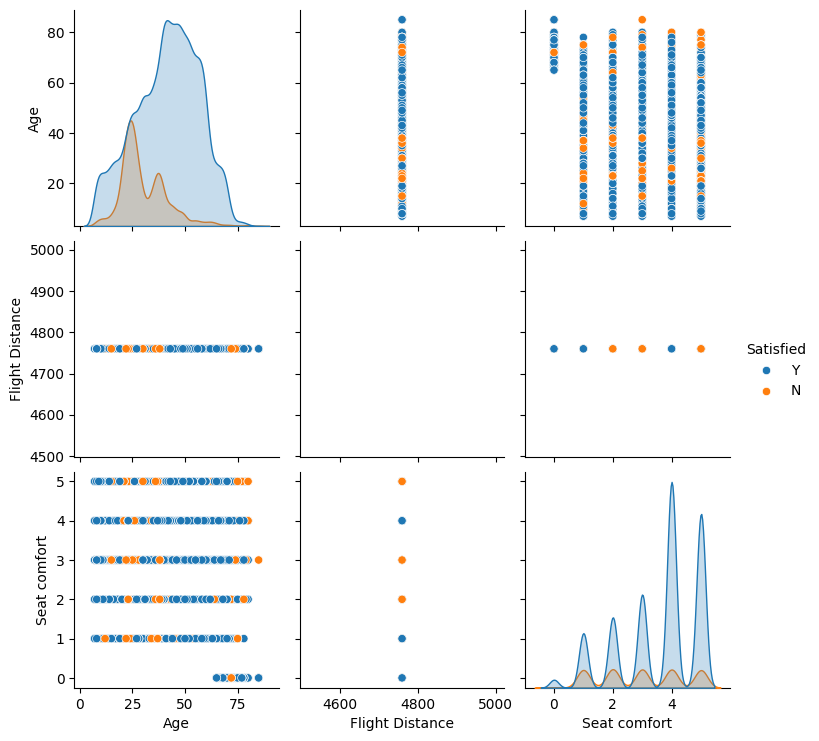

In [11]:
sns.pairplot(df[['Age', 'Flight Distance', 'Seat comfort', 'Satisfied']], hue="Satisfied")
plt.show()

# **Step 5: Train-Test Split & Feature Scaling**

# Step 5.1 - Identifing the Categorical Columns

In [12]:
print(df.dtypes)

Ref                                    int64
id                                     int64
Gender                                 int64
Satisfied                             object
Age                                    int64
Age Band                              object
Type of Travel                         int64
Class                                  int64
Flight Distance                        int64
Destination                            int64
Continent                              int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin se

# Step 5.2 : Convert Categorical Columns to Numeric

In [13]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

print("Categorical Columns Encoded Successfully!")


Categorical Columns Encoded Successfully!


# Step 5.3: Apply Train-Test Split and Scale Only Numeric Features

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Splitdata
X = df.drop(columns=['Satisfied'])
y = df['Satisfied']

# stratifiedsampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# columns scaling
numerical_cols = X_train.select_dtypes(include=['number']).columns

# StandardScaler -> numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(" Data Split and Scaled Successfully!")


 Data Split and Scaled Successfully!


# Step 6: Train ML Models

**Logistic Regression**

In [15]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_pred))

Logistic Regression Accuracy: 0.911055560035481


**Random Forest (With Hyperparameter Tuning)**

In [16]:
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20]}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
rf_pred = best_rf.predict(X_test)

print("Random Forest Best Accuracy:", accuracy_score(y_test, rf_pred))


Random Forest Best Accuracy: 0.988146117248609


***XGBoost (With Hyperparameter Tuning)***

In [1]:
!pip install xgboost==1.7.6 scikit-learn==1.2.2

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6]
}

grid_xgb = GridSearchCV(XGBClassifier(), xgb_params, cv=5, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_
xgb_pred = best_xgb.predict(X_test)

print("XGBoost Best Accuracy:", accuracy_score(y_test, xgb_pred))


XGBoost Best Accuracy: 0.9922586888154181


# Step 7: Model Evaluation

**Classification Report & Confusion Matrix**

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.71      0.74      2217
           1       0.94      0.96      0.95     10184

    accuracy                           0.91     12401
   macro avg       0.86      0.83      0.84     12401
weighted avg       0.91      0.91      0.91     12401



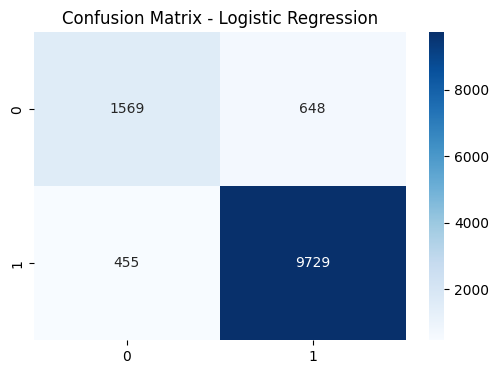

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      2217
           1       0.99      1.00      0.99     10184

    accuracy                           0.99     12401
   macro avg       0.98      0.98      0.98     12401
weighted avg       0.99      0.99      0.99     12401



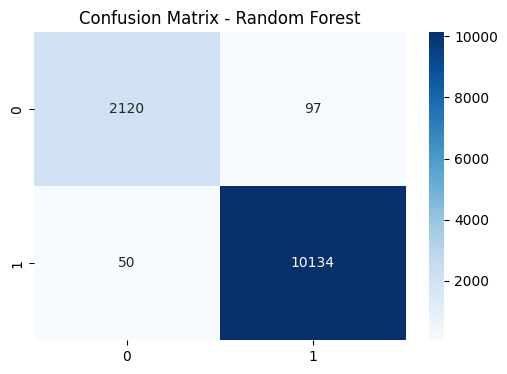

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      2217
           1       0.99      1.00      1.00     10184

    accuracy                           0.99     12401
   macro avg       0.99      0.98      0.99     12401
weighted avg       0.99      0.99      0.99     12401



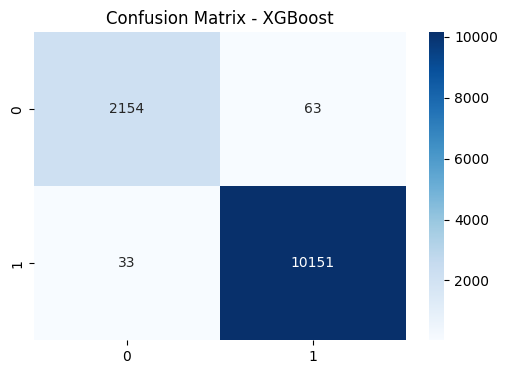

In [20]:
models = {'Logistic Regression': log_reg, 'Random Forest': best_rf, 'XGBoost': best_xgb}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


**AUC-ROC Curve**


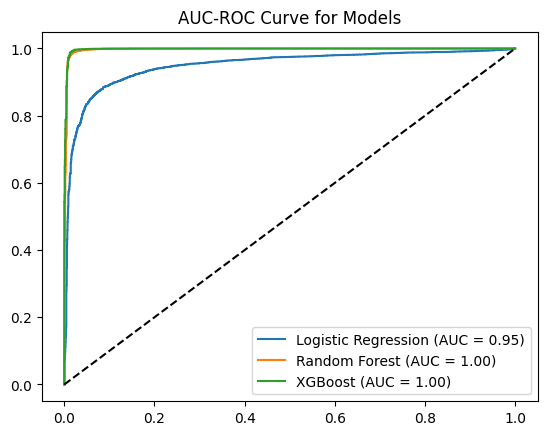

In [21]:
for name, model in models.items():
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.title("AUC-ROC Curve for Models")
plt.show()

# Feature Importance (SHAP - XGBoost)

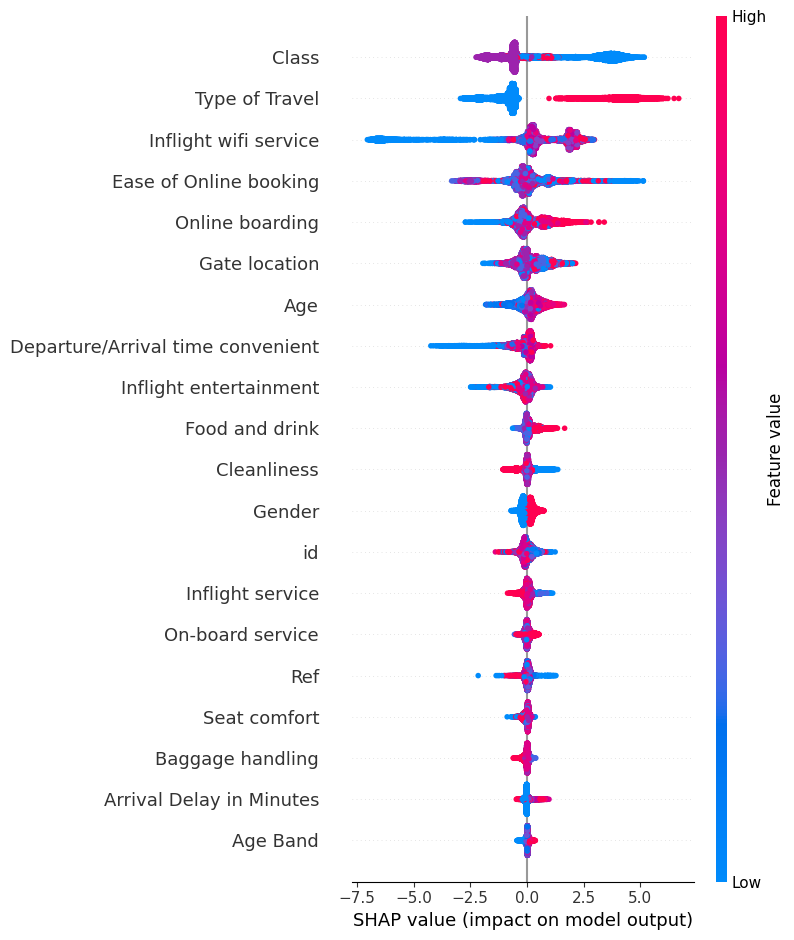

In [22]:
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Step 8: Final Model Recommendation

In [23]:
print("Final Recommendation: XGBoost provides the best accuracy and feature interpretability.")

Final Recommendation: XGBoost provides the best accuracy and feature interpretability.
